In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [2]:
tracts_df = pd.read_csv('./data/dataframes/final_tracts.csv')

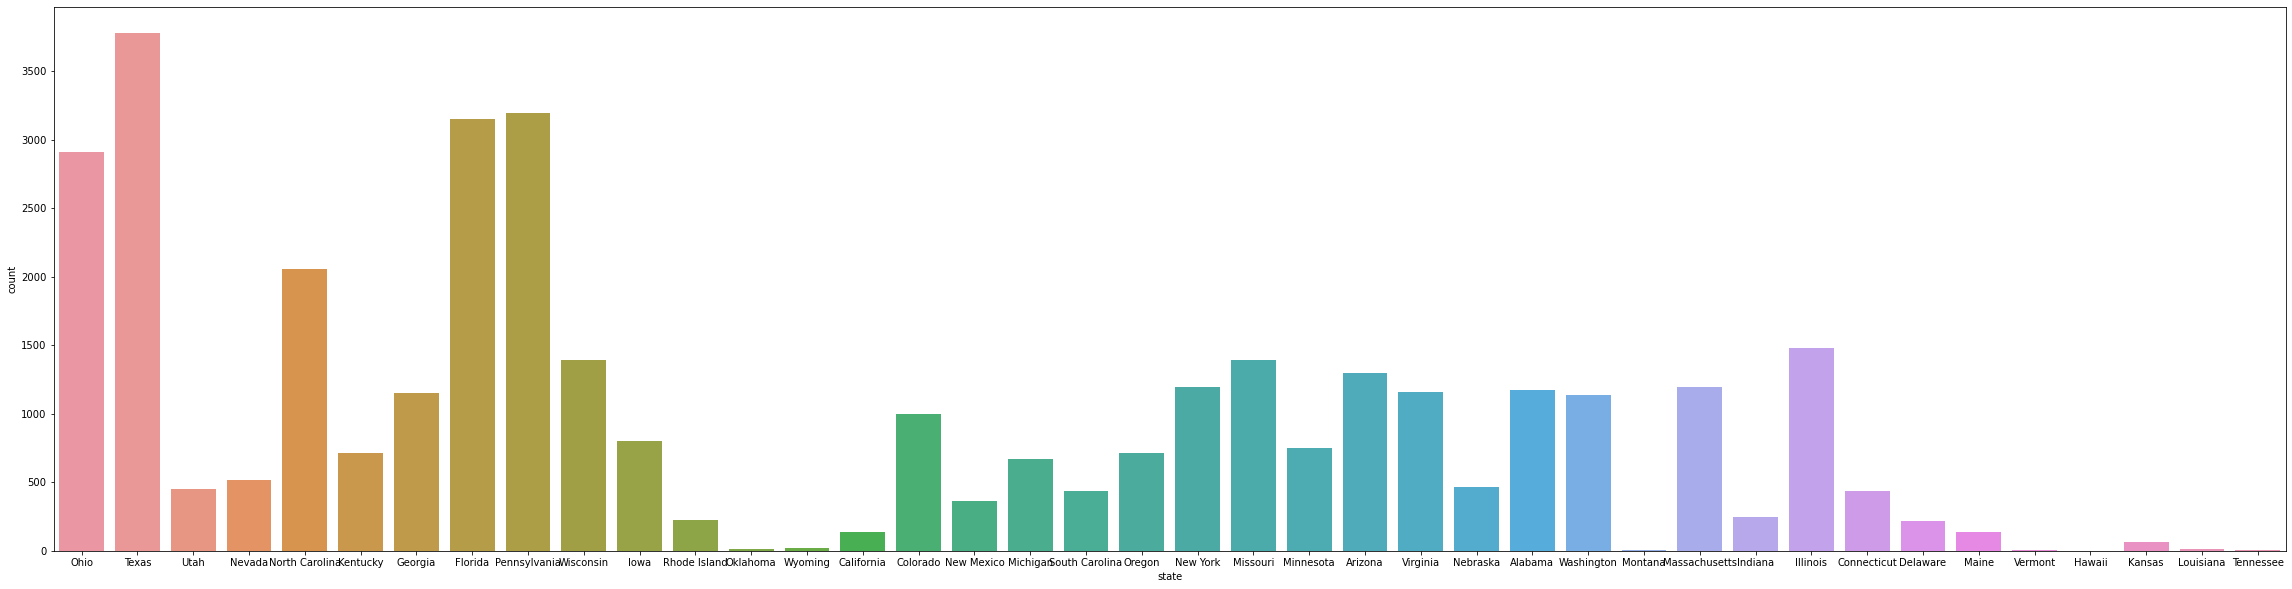

In [3]:
fig, ax = plt.subplots(figsize=(40, 10))
ax=sns.countplot('state', data=tracts_df)

In [4]:
tracts_df.state.value_counts()

Texas             3778
Pennsylvania      3197
Florida           3154
Ohio              2907
North Carolina    2059
Illinois          1482
Wisconsin         1392
Missouri          1390
Arizona           1294
Massachusetts     1196
New York          1194
Alabama           1173
Virginia          1156
Georgia           1150
Washington        1138
Colorado           999
Iowa               801
Minnesota          748
Oregon             715
Kentucky           714
Michigan           669
Nevada             517
Nebraska           469
Utah               448
South Carolina     438
Connecticut        433
New Mexico         367
Indiana            244
Rhode Island       224
Delaware           214
California         140
Maine              139
Kansas              61
Wyoming             17
Oklahoma            14
Louisiana           12
Montana              5
Vermont              5
Tennessee            4
Hawaii               1
Name: state, dtype: int64

**CLEANING**
- States with a low amount of entries may cause issues with modeling
- I will drop those belonging to states with < 400 entries (14)

In [5]:
drop_states = list(tracts_df.state.value_counts().keys()[-14:])

for index, row in tracts_df.iterrows():
    if row.state in drop_states:
        tracts_df.drop(index, inplace=True)

## Feature Engineering - Census Regions & Divisions

**OBSERVATION**
- Creating a dummy variable for every census tract (<30,000), or every state (26) is very inefficient
- I will group the states into the 8 regions designated by the Census
    1. Pacific
    2. Mountain
    3. West North Central
    4. West South Central
    5. East North Central
    6. East South Central  
    7. North East
    8. Mid Atlantic


In [6]:
region_dict = {'pcf' : ['Oregon', 'Washington'],
'mt' : ['Nevada', 'Utah', 'Arizona', 'Colorado'],
'wnc' : ['Nebraska', 'Minnesota', 'Iowa', 'Missouri'],
'wsc' : ['Texas'],
'enc' : ['Wisconsin', 'Illinois', 'Michigan', 'Ohio'],
'ma' : ['Pennsylvania', 'New York'],
'ne' : ['Massachusetts', 'Connecticut'],
'sa' : ['Virginia', 'Georgia', 'South Carolina', 'Florida', 'North Carolina'],
'esc' : ['Alabama', 'Kentucky']}

state_list = list(tracts_df['state'])
region_list = []

for state in state_list:
    for key, value in region_dict.items():
        if state in value:
            region_list.append(key)
            
tracts_df['region'] = region_list

<AxesSubplot:xlabel='region', ylabel='count'>

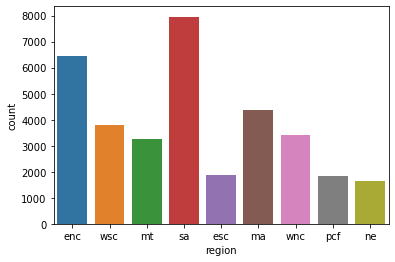

In [7]:
sns.countplot('region', data=tracts_df)

## National EDA

In [8]:
tracts_df[tracts_df['eviction.rate'] > 90 ]

,Unnamed: 0,name,state,GEOID,population,poverty.rate,renter.occupied.households,pct.renter.occupied,median.gross.rent,median.household.income,...,pct.nh.pi,pct.multiple,pct.other,eviction.filings,evictions,eviction.rate,eviction.filing.rate,male,female,region
8206,8206,163.0_Bronx County,New York,3.600502e+10,340.0,0.0,1.0,0.00,0.0,0.0,...,0.0,0.000,0.00,13.5,1.5,150.00,1350.00,39.5,60.5,ma
9122,9122,18.0_Kings County,New York,3.604700e+10,2560.0,0.0,5.0,0.00,0.0,0.0,...,0.0,1.330,0.00,44.0,8.0,166.67,846.15,95.7,4.3,ma
18459,18459,36.05_Mobile County,Alabama,1.097004e+09,1371.0,0.0,1.0,0.00,0.0,0.0,...,0.0,2.525,0.33,9.0,7.5,775.00,1312.50,39.7,60.3,esc
23123,23123,5007.0_Hartford County,Connecticut,9.003501e+09,1095.0,0.0,1.0,0.00,0.0,0.0,...,0.0,2.590,0.09,1.0,1.0,100.00,100.00,98.7,1.3,ne
36007,36007,9805.0_Hillsborough County,Florida,1.205798e+10,17.0,0.0,1.0,33.33,998.0,50270.0,...,0.0,0.720,0.00,16.0,6.0,300.00,700.00,0.0,100.0,sa


In [9]:
tracts_df.drop(tracts_df[tracts_df['eviction.rate'] > 90].index, inplace=True)

**CLEANING**
- Eviction rates >= 90 are misleading, as these high rates are due to the fact that an eviction has occured in a census tract with a very low amount of renters (<5)
- I am dropping these values for the sake of extreme outlier removal

In [ ]:
sns.scatterplot('poverty.rate', 'eviction.rate', data=tracts_df)

In [ ]:
sns.distplot(tracts_df['poverty.rate'])

**OBSERVATION**
- eviction rate seems to decerease as poverty rate increases, which seems counterintuitive 
- this could be due to the fact that ~80% of the data has a poverty rate below 20%

In [ ]:
sns.scatterplot('poverty.rate', 'eviction.filing.rate', data=tracts_df)

In [ ]:
sns.scatterplot('pct.af.am', 'eviction.rate', data=tracts_df)

In [ ]:
sns.scatterplot('pct.af.am', 'rent.burden', data=tracts_df)

In [ ]:
sns.scatterplot('pct.white', 'eviction.rate', data=tracts_df)

In [ ]:
sns.scatterplot('pct.white', 'rent.burden', data=tracts_df)

In [ ]:
sns.scatterplot('rent.burden', 'eviction.rate', data=tracts_df)

In [ ]:
sns.scatterplot('eviction.rate', 'eviction.filing.rate', data=tracts_df)

**OBSERVATION**
- The relationship between eviction filing rate and eviction rate seems to have the strongest correlation
    - This is to be expected as there needs to be an eviction filing before an actual eviction takes place 

## Feature Engineering - Evictions/Filings Ratio

- This ratio reflects the percentage of the eviction filings that actually resulted in evictions 

In [10]:
tracts_df['ef.ratio'] = (tracts_df['evictions'] / tracts_df['eviction.filings'])*100

In [11]:
tracts_df.fillna(0, inplace=True)

In [ ]:
tracts_df['ef.ratio']

In [ ]:
sns.scatterplot('ef.ratio', 'eviction.rate', data=tracts_df)

In [ ]:
tracts_df[tracts_df['ef.ratio'] == 100].describe()

In [ ]:
tracts_df[(tracts_df['ef.ratio'] == 100) & (tracts_df['evictions'] < 10)]

**OBSERVATION**
- As the % of evictions by filings increases, so does eviction rate
- % of evictions by filings seems to platue when eviction rate is ~20% (with occasional outliers) 
- ratios of 100% appear to be occuring with low evictions ( 3% of the 100% ratios are of 10 evicitons and up) 

# Majority Race T-test

Exploring if the eviction rate of a census tract with a majority (>50.4) of a particular race has a significant different between census tracts in which said race is a minority (<=50.4)

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
maj_white = tracts_df[tracts_df['pct.white'] > 50.4]


min_white = tracts_df[tracts_df['pct.white'] <= 50.4]


In [ ]:
white_ttest = ttest_ind(maj_white['eviction.rate'], min_white['eviction.rate'])

In [ ]:
white_ttest

In [ ]:
print('Majority White Eviction Rate:', maj_white['eviction.rate'].median())
print('Minority White Eviction Rate:', min_white['eviction.rate'].median())

In [ ]:
sns.scatterplot('pct.white', 'eviction.rate', data=maj_white)

In [ ]:
sns.scatterplot('pct.white', 'eviction.rate', data=min_white)

**OBSERVATION**
- The eviction rate for majority white census tracts is ~2% lower than census tracts in which white is the minority race
- p-value of 0.0 indicates a significant difference between the two populations

In [ ]:
maj_afam = tracts_df[tracts_df['pct.af.am'] > 50.4]
min_afam = tracts_df[tracts_df['pct.af.am'] <= 50.4]

afam_ttest = ttest_ind(maj_afam['eviction.rate'], min_afam['eviction.rate'])

print(afam_ttest)
print('Majority Eviction Rate:', maj_afam['eviction.rate'].median())
print('Minority Eviction Rate:', min_afam['eviction.rate'].median())



In [ ]:
sns.scatterplot('pct.af.am', 'eviction.rate', data=maj_afam)

In [ ]:
sns.scatterplot('pct.af.am', 'eviction.rate', data=min_afam)

**OBSERVATION**
- The eviction rate for majority aferican american census tracts is >3% higher than census tracts in which aferican american is the minority race
- p-value of 0.0 indicates a significant difference between the majority and minority populations

In [ ]:
maj_hispanic = tracts_df[tracts_df['pct.hispanic'] > 50.4]
min_hispanic = tracts_df[tracts_df['pct.hispanic'] <= 50.4]

hispanic_ttest = ttest_ind(maj_hispanic['eviction.rate'], min_hispanic['eviction.rate'])

print(hispanic_ttest[1])
print('Majority Eviction Rate:', maj_hispanic['eviction.rate'].median())
print('Minority Eviction Rate:', min_hispanic['eviction.rate'].median())


In [ ]:
sns.scatterplot('pct.hispanic', 'eviction.rate', data=maj_hispanic)

In [ ]:
sns.scatterplot('pct.hispanic', 'eviction.rate', data=min_hispanic)

**OBSERVATION**
- The eviction rate for majority hispanic census tracts is ~0.6% higher than census tracts in which hispanic is the minority race
- miniscule p-value indicates a significant difference between the two populations

In [ ]:
maj_amind = tracts_df[tracts_df['pct.am.ind'] > 50.4]
min_amind = tracts_df[tracts_df['pct.am.ind'] <= 50.4]

amind_ttest = ttest_ind(maj_amind['eviction.rate'], min_amind['eviction.rate'])

print(amind_ttest[1])
print('Majority Eviction Rate:', maj_amind['eviction.rate'].median())
print('Minority Eviction Rate:', min_amind['eviction.rate'].median())


**OBSERVATION**
- The eviction rate for majority native american census tracts is 0%

In [ ]:
print('Majority Eviction Rate:', maj_amind['eviction.rate'].mean())
print('Minority Eviction Rate:', min_amind['eviction.rate'].mean())

In [ ]:
print(maj_amind.shape[0])
print(min_amind.shape[0])

In [ ]:
maj_asian = tracts_df[tracts_df['pct.asian'] > 50.4]
min_asian = tracts_df[tracts_df['pct.asian'] <= 50.4]

asian_ttest = ttest_ind(maj_asian['eviction.rate'], min_asian['eviction.rate'])

print(asian_ttest[1])
print('Majority Eviction Rate:', maj_asian['eviction.rate'].median())
print('Minority Eviction Rate:', min_asian['eviction.rate'].median())


**OBSERVATION**
- The eviction rate for majority asian census tracts is ~2% lower than census tracts in which asian is the minority race
- p-value <0.05 indicates a significant difference between the two populations

In [ ]:
maj_nhpi = tracts_df[tracts_df['pct.nh.pi'] > 50.4]
min_nhpi = tracts_df[tracts_df['pct.nh.pi'] <= 50.4]

nhpi_ttest = ttest_ind(maj_nhpi['eviction.rate'], min_nhpi['eviction.rate'])

print(nhpi_ttest[1])
print('Majority Eviction Rate:', maj_nhpi['eviction.rate'].median())
print('Minority Eviction Rate:', min_nhpi['eviction.rate'].median())


In [ ]:
maj_mult = tracts_df[tracts_df['pct.multiple'] > 50.4]
min_mult = tracts_df[tracts_df['pct.multiple'] <= 50.4]

mult_ttest = ttest_ind(maj_mult['eviction.rate'], min_mult['eviction.rate'])

print(mult_ttest[1])
print('Majority Eviction Rate:', maj_mult['eviction.rate'].median())
print('Minority Eviction Rate:', min_mult['eviction.rate'].median())


In [ ]:
maj_other = tracts_df[tracts_df['pct.other'] > 50.4]
min_other = tracts_df[tracts_df['pct.other'] <= 50.4]

other_ttest = ttest_ind(maj_other['eviction.rate'], min_other['eviction.rate'])

print(other_ttest[1])
print('Majority Eviction Rate:', maj_other['eviction.rate'].median())
print('Minority Eviction Rate:', min_other['eviction.rate'].median())


**OBSERVATION**
- There are no entries of census tracts in which native hawaiins/pacific islanders, multiple (races), or other (race) have a majority

# Majority Gender T-test

In [ ]:
maj_male = tracts_df[tracts_df['male'] > 50.4]
min_male = tracts_df[tracts_df['male'] <= 50.4]

male_ttest = ttest_ind(maj_male['eviction.rate'], min_male['eviction.rate'])

print(male_ttest[1])
print('Majority Eviction Rate:', maj_male['eviction.rate'].median())
print('Minority Eviction Rate:', min_male['eviction.rate'].median())


In [ ]:
sns.scatterplot('male', 'eviction.rate', data=maj_male)

In [ ]:
sns.scatterplot('male', 'eviction.rate', data=min_male)

In [ ]:
sns.scatterplot('male', 'eviction.rate', data=tracts_df)

In [ ]:
maj_female = tracts_df[tracts_df['female'] > 50.4]
min_female = tracts_df[tracts_df['female'] <= 50.4]

female_ttest = ttest_ind(maj_female['eviction.rate'], min_female['eviction.rate'])

print(female_ttest[1])
print('Majority Eviction Rate:', maj_female['eviction.rate'].median())
print('Minority Eviction Rate:', min_female['eviction.rate'].median())


In [ ]:
sns.scatterplot('female', 'eviction.rate', data=tracts_df)

**OBSERVATION**
- Eviction rates in majority female census tracts are 0.3% higher than male majority census tracts
- p-values all lower than 0.05

## State Level EDA


In [ ]:
state_df.reset_index(inplace=True)

In [ ]:
state_df

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot('eviction.rate', 'state', data=state_df.sort_values('eviction.rate', ascending=False))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot('eviction.filing.rate', 'state', data=state_df.sort_values('eviction.filing.rate', ascending=False))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot('renter.occupied.households', 'state', data=state_df.sort_values('renter.occupied.households',ascending=False))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot('poverty.rate', 'state', data=state_df.sort_values('poverty.rate', ascending=False))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot('rent.burden', 'state', data=state_df.sort_values('rent.burden', ascending=False))

# Modeling

### Checking Assumptions for Linear Regression

#### 1.  Multicullinearity

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(data = tracts_df.corr(), center=0, annot=True)

**OBSERVATION**
1. Correlations .75 and above:
    - eviction.filings vs evitions
    - eviction.filings vs eviction.filings.rate
    - male vs female 
2. Dropping evictions and eviction.filing.rate as their values are reflected in eviction.filings
    - dropping renter.occupied.households (despite being slightly lower than 0.75) due to value being reflected in pct.renter.occupied
3. Dropping male column as insight will be inferrable based on findings of female variable 

In [12]:
model_df = tracts_df.drop(['evictions', 'eviction.filing.rate', 'renter.occupied.households', 
                           'Unnamed: 0', 'name', 'GEOID', 'male', 'pct.white', 'state'], axis=1)

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(data = model_df.corr(), center=0, annot=True)

In [13]:
region_dummies = pd.get_dummies(tracts_df['region'], drop_first=True)
model_df = pd.concat([model_df, region_dummies], axis=1)
model_df.drop('region', axis=1, inplace=True)

In [14]:
model_df.columns = model_df.columns.str.replace(".","_")

In [ ]:
model_df

## Linear Regression

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
import statsmodels.api as sm


In [16]:
def linreg_model(df, target):
    outcome = target
    predictors = df.drop(target, axis=1)
    predictor_variables = "+".join(predictors.columns)
    formula = outcome + '~' + predictor_variables
    model_baseline = ols(formula=formula, data=df).fit()
     
    X = model_df.drop("eviction_rate", axis = 1)
    y = model_df['eviction_rate']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

    baseline_linreg = LinearRegression()

    baseline_linreg.fit(X_train, y_train)

    y_pred = baseline_linreg.predict(X_test)

    residuals = y_pred - y_test
    
    
    mse_train = mean_squared_error(y_train, baseline_linreg.predict(X_train))
    mse_test = mean_squared_error(y_test, y_pred)

    residuals = model_baseline.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

    print("Train RMSE:", np.sqrt(mse_train))
    print("Test RMSE:", np.sqrt(mse_test))
    print('Test Difference:', np.sqrt(mse_test) - np.sqrt(mse_train))
    fig.show()
    
    return model_baseline.summary()


In [ ]:
linreg_model(model_df, 'eviction_rate')

# Random Forrest 


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import math
import statistics as stat

In [18]:
def rf_report(classifier):
    
    # calculating variance
    var_train = explained_variance_score(y_train, classifier.predict(X_train_scaled))
    var_test = explained_variance_score(y_test, classifier.predict(X_test_scaled))
    
    #calculating max error
    max_error_train = max_error(y_train, classifier.predict(X_train_scaled))
    max_error_test = max_error(y_test, classifier.predict(X_test_scaled))
    
    #calculating RMSE
    rmse_train = math.sqrt(mean_squared_error(y_train, classifier.predict(X_train_scaled)))
    rmse_test = math.sqrt(mean_squared_error(y_test, classifier.predict(X_test_scaled)))
    
    #calculating R2
    r_sq_train = r2_score(y_train, classifier.predict(X_train_scaled))
    r_sq_test = r2_score(y_test, classifier.predict(X_test_scaled))
 

    #printing scores
    print('Variance --------------------------------------------')
    print('Train Variance: {}'.format(var_train))
    print('Test Variance: {}'.format(var_test))
    print('Max Error --------------------------------------------')
    print('Max Error Train: {}'.format(max_error_train))
    print('Max Error Test: {}'.format(max_error_test))
    print('RMSE --------------------------------------------')
    print('Train RMSE: {}'.format(rmse_train))
    print('Test RMSE: {}'.format(rmse_test))
    print('R2 --------------------------------------------')
    print('R2 Train: {}'.format(r_sq_train))
    print('R2 Test: {}'.format(r_sq_test))

    
    

### Random Forest Baseline

1. Continuing to use the same features used in the linear regression model to better compare performance

In [19]:
X = model_df.drop("eviction_rate", axis = 1)
y = model_df['eviction_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
forest_base = RandomForestRegressor()
forest_base_model = forest_base.fit(X_train_scaled, y_train)

In [ ]:
rf_report(forest_base)

In [ ]:
max_depth = []
for classifier in forest_base_model:
    max_depth.append(classifier.tree_.max_depth)

In [ ]:
stat.median(max_depth)

**OBSERVATION**
- While the training model is nearly completely learning the training data, it still achieves a good R2 on the testing data
- Overfitting occuring around depth of 31  

In [20]:
def plot_feature_importances_base(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    

In [ ]:
plot_feature_importances_base(forest_base_model)

**OBSERVATION**
- As expected, the random foreset model puts much more importance on the continuous features 
- Eviction filings are by the the most important feature, followed by pct_renter_occupied

## Random Forest v2

In [ ]:
forest_v2 = RandomForestRegressor()

param_grid = {'max_depth': [20, 25, 30],
             'min_samples_split': [10, 15, 20],
             'min_samples_leaf': [20, 30, 40]}

forest_v2_model = GridSearchCV(estimator = forest_v2, param_grid=param_grid, cv=3)
forest_v2_model.fit(X_train_scaled, y_train)

In [21]:
def report_grid(model):
    params = print(model.best_params_)
    print(params)
    return rf_report(model)

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), model.best_estimator_.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
report_grid(forest_v2_model)

**OBSERVATION**
- test R2 is lower by ~3% compared to baseline
- RMSE is higher by 0.1
- slighly worse performance after parameter optimization via gridsearch could be due to 


In [ ]:
plot_feature_importances(forest_v2_model)

## XGBoost

In [22]:
import xgboost
from xgboost import XGBRegressor

In [ ]:
xgb_base = XGBRegressor()
xgb_base_model = xgb_base.fit(X_train_scaled, y_train)

In [ ]:
rf_report(xgb_base)

In [ ]:
plot_feature_importances_base(xgb_base)

**OBSERVATION**
- This model is performing on par with the decision random forest basemodel
    - higher R2 by ~3%
- XGBoost is relying more on the cateogorical (region) features than the randomforest model
    - most important regions are ma(mid atlantic) and mt (mountain)

In [ ]:
xgb_v2 = XGBRegressor()

param_grid = {
    'learning_rate' : [0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2],
    'sub_sample': [0.5, 0.7],
    
}

xgb_v2_model = GridSearchCV(estimator = xgb_v2, param_grid=param_grid, cv=3)
xgb_v2_model.fit(X_train_scaled, y_train)

In [ ]:
report_grid(xgb_v2_model)

In [ ]:
plot_feature_importances(xgb_v2_model)

**OBSERVATION**
- Optimization has improved R2 by 1%, and lowered RMSE by 0.04
- Placing much more importance on MT region than MA region compared to basemodel 

In [ ]:
mt = tracts_df[tracts_df['region'] == 'mt']

In [ ]:
sns.scatterplot('eviction.filings', 'eviction.rate', data=mt)

In [ ]:
sns.scatterplot('eviction.filings', 'eviction.rate', data=tracts_df)

In [ ]:
tracts_df[(tracts_df['eviction.rate'] > 8) & (tracts_df['evictions'] < 10)]

In [ ]:
y.describe()

## MLN 

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn import metrics


In [ ]:
base_nn = Sequential()
base_nn.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
base_nn.add(Dense(1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

base_nn.compile(loss='mean_squared_error', optimizer='adam')
base_nn.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
            verbose=2, epochs=500)

In [ ]:
pred = base_nn.predict(X_test_scaled)
score = math.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


In [ ]:
print(r2_score(y_train, base_nn.predict(X_train_scaled)))
print(r2_score(y_test, base_nn.predict(X_test_scaled)))

### Deeper Network 

In [ ]:
nn_v2 = Sequential()
nn_v2.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
nn_v2.add(Dense(16, activation='relu'))
nn_v2.add(Dense(1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

nn_v2.compile(loss='mean_squared_error', optimizer='adam')
nn_v2.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
            verbose=2, epochs=500)

In [ ]:
pred = nn_v2.predict(X_test_scaled)
score = math.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


In [ ]:
print(r2_score(y_train, nn_v2.predict(X_train_scaled)))
print(r2_score(y_test, nn_v2.predict(X_test_scaled)))

## Different Features

- Considering eviction.filings is consistantly the most important feature, it is worth running basemodels that utilize eviction.filing.rate
- Based on the eviction.filing.rate and eviction.rate calculations (# eviction filings; evictions/# renter occupied households), I will need to drop any features that would give the model the ability to perfectly calculate the eviction rate

In [24]:
drop_pop_df = tracts_df.drop(['renter.occupied.households', 'pct.renter.occupied', 'ef.ratio', 'eviction.filings', 'Unnamed: 0', 'name', 'GEOID', 
                              'male', 'pct.white', 'state'], axis=1)

In [25]:
region_dummies = pd.get_dummies(drop_pop_df['region'], drop_first=True)
drop_pop_df = pd.concat([drop_pop_df, region_dummies], axis=1)
drop_pop_df.drop('region', axis=1, inplace=True)

In [26]:
X = drop_pop_df.drop("eviction.rate", axis = 1)
y = drop_pop_df['eviction.rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
xgb_base = XGBRegressor()
xgb_base_model = xgb_base.fit(X_train_scaled, y_train)

In [ ]:
rf_report(xgb_base)

In [ ]:
plot_feature_importances_base(xgb_base_model)

In [ ]:
xgb_v2 = XGBRegressor()

param_grid = {
    'learning_rate' : [0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2],
    'sub_sample': [0.5, 0.7],
    
}

xgb_v2_model = GridSearchCV(estimator = xgb_v2, param_grid=param_grid, cv=3)
xgb_v2_model.fit(X_train_scaled, y_train)

In [ ]:
report_grid(xgb_v2_model)

In [ ]:
plot_feature_importances(xgb_v2_model)

## MLN 

In [ ]:
base_nn = Sequential()
base_nn.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
base_nn.add(Dense(1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

base_nn.compile(loss='mean_squared_error', optimizer='adam')
base_nn.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
            verbose=2, epochs=500)

In [ ]:
pred = base_nn.predict(X_test_scaled)
score = math.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


In [ ]:
print(r2_score(y_train, base_nn.predict(X_train_scaled)))
print(r2_score(y_test, base_nn.predict(X_test_scaled)))

### Deeper Network 

In [ ]:
nn_v2 = Sequential()
nn_v2.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
nn_v2.add(Dense(16, activation='relu'))
nn_v2.add(Dense(1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

nn_v2.compile(loss='mean_squared_error', optimizer='adam')
nn_v2.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
            verbose=2, epochs=500)

In [ ]:
pred = nn_v2.predict(X_test_scaled)
score = math.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


In [ ]:
print(r2_score(y_train, nn_v2.predict(X_train_scaled)))
print(r2_score(y_test, nn_v2.predict(X_test_scaled)))

### Wider Network 

In [ ]:
nn_v2 = Sequential()
nn_v2.add(Dense(X.shape[1]*2, input_dim=X.shape[1], activation='relu'))
nn_v2.add(Dense(25, activation='relu'))
nn_v2.add(Dense(1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

nn_v2.compile(loss='mean_squared_error', optimizer='adam')
nn_v2.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
            verbose=2, epochs=500)

In [ ]:
pred = nn_v2.predict(X_test_scaled)
score = math.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


print(r2_score(y_train, nn_v2.predict(X_train_scaled)))
print(r2_score(y_test, nn_v2.predict(X_test_scaled)))

In [ ]:
nn_v2 = Sequential()
nn_v2.add(Dense(X.shape[1]*2, input_dim=X.shape[1], activation='relu'))
nn_v2.add(Dense(25, activation='relu'))
nn_v2.add(Dense(16, activation='relu'))
nn_v2.add(Dense(1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

nn_v2.compile(loss='mean_squared_error', optimizer='adam')
nn_v2.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
            verbose=2, epochs=500)

In [ ]:
pred = nn_v2.predict(X_test_scaled)
score = math.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


print(r2_score(y_train, nn_v2.predict(X_train_scaled)))
print(r2_score(y_test, nn_v2.predict(X_test_scaled)))

### Deeper Still

In [ ]:
# nn_v2 = Sequential()
# nn_v2.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
# nn_v2.add(Dense(16, activation='relu'))
# nn_v2.add(Dense(16, activation='relu'))
# nn_v2.add(Dense(1))

# earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

# nn_v2.compile(loss='mean_squared_error', optimizer= optimizers.Adam(learning_rate = 0.005))
# history = nn_v2.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
#             verbose=2, epochs=500)

In [ ]:
# history_dict=history.history


In [ ]:
# pred = nn_v2.predict(X_test_scaled)
# score = math.sqrt(metrics.mean_squared_error(pred,y_test))
# print("Final score (RMSE): {}".format(score))


# print(r2_score(y_train, nn_v2.predict(X_train_scaled)))
# print(r2_score(y_test, nn_v2.predict(X_test_scaled)))

In [ ]:
# loss_values = history_dict['loss']
# val_loss_values=history_dict['val_loss']
# plt.figure(figsize=(20,13))
# plt.plot(loss_values,'bo',label='training loss')
# plt.plot(val_loss_values,'r',label='val training loss')

In [ ]:
# history.history

In [ ]:
# nn_v3 = Sequential()
# nn_v3.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
# nn_v3.add(Dense(X.shape[1], activation='relu'))
# nn_v3.add(Dense(X.shape[1], activation='relu'))
# nn_v3.add(Dense(X.shape[1], activation='relu'))
# nn_v3.add(Dense(X.shape[1]//2, activation='relu'))
# nn_v3.add(Dense(1))

# earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='auto')

# nn_v3.compile(loss='mean_squared_error', optimizer='adam')
# nn_v3.fit(X_train_scaled, y_train, validation_split=0.1, callbacks=[earlystopper],
#             verbose=2, epochs=500)

In [ ]:
# pred = nn_v3.predict(X_test_scaled)
# score = math.sqrt(metrics.mean_squared_error(pred,y_test))
# print("Final score (RMSE): {}".format(score))


In [ ]:
# print(r2_score(y_train, nn_v3.predict(X_train_scaled)))
# print(r2_score(y_test, nn_v3.predict(X_test_scaled)))

# Outlier Detection and Removal

**OBSERVATION**
- Thus far the highest r2 values achieved (via supervised learning techniques) have been 87% (XGBoost)
- Considering I have not removed any outliers after initial cleaning, detecting and removing these outliers could yield better results

## Isolation Forest

- I am starting with Isolation Forset as it functions well with multi-dimensional data

In [27]:
from sklearn.ensemble import IsolationForest

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.boxplot(y)

In [ ]:
outliers = y > 9

In [ ]:
len(y)/outliers.sum()

**OBSERVATION**
- Based on the boxplot and calculation above, approx 15% of eviction rates are outliers
- I will use this percentage as the maximum contamination, and train several models with decreasing contaminations to see which gives the best R2

In [28]:
i = [0.15, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01]


In [61]:
def iso_forest(contamination_list):

    contamination_dict = {}

    for contamination in contamination_list:
        print('CURRENT CONTAMINATION: ', contamination)
        
        #fitting IsolationForest to all data
        isoforest = IsolationForest(contamination = contamination, n_estimators=drop_pop_df.shape[1], random_state=42)
        isoforest_model =isoforest.fit(X)
        
        #assinging IsolationForest predictions (-1 = Outlier, 1 = Non-Outlier) 
        eviction_rate_outliers = pd.Series(isoforest_model.predict(X))

        
        iso_df = tracts_df.drop(['renter.occupied.households', 'pct.renter.occupied', 'ef.ratio', 'eviction.filings', 
                                 'Unnamed: 0', 'name', 'GEOID', 
                                  'male', 'pct.white', 'state'], axis=1)
        region_dummies = pd.get_dummies(iso_df['region'], drop_first=True)
        iso_df = pd.concat([iso_df, region_dummies], axis=1)
        iso_df.drop('region', axis=1, inplace=True)

        iso_tracts = iso_df
        iso_tracts.reset_index(inplace=True)
        iso_tracts.drop('index', axis=1, inplace=True)

        #iterating through IsolationForest predictions
        for i in range(len(eviction_rate_outliers)):
            if eviction_rate_outliers[i] == -1:
                #if the datapoint is an outlier, drop it from the dataset
                iso_tracts.drop(i, inplace=True)


        #preprocessing data        
        X2 = iso_tracts.drop("eviction.rate", axis = 1)
        y2 = iso_tracts['eviction.rate']

        #making certain variable accessible outside of function to be later used in gridsearch optimization
        X2_train, X2_test, iso_forest.y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state = 25)

        #scaling data
        scaler = StandardScaler()

        iso_forest.X2_train_scaled = scaler.fit_transform(X2_train)
        X2_test_scaled = scaler.transform(X2_test)
    
        #training model on OUTLIER REMOVED data
        iso_forest.xgb_iso = XGBRegressor().fit(iso_forest.X2_train_scaled, iso_forest.y2_train)
        
        rf_report(iso_forest.xgb_iso)
        
        #populating contamination_dict with contamination's corresponding R2 score
        #model is tested on FULL DATA (outliers included)
        contamination_dict[str(contamination)] = r2_score(y_test, iso_forest.xgb_iso.predict(X_test_scaled))   
    print(contamination_dict)

In [56]:
iso_forest(i)

CURRENT CONTAMINATION:  0.15
Variance --------------------------------------------
Train Variance: 0.8602287894084051
Test Variance: 0.8652767287413456
Max Error --------------------------------------------
Max Error Train: 31.373409652709974
Max Error Test: 22.441638946533203
RMSE --------------------------------------------
Train RMSE: 1.312340251912274
Test RMSE: 1.3047705973652872
R2 --------------------------------------------
R2 Train: 0.8572028579450892
R2 Test: 0.8615845941319555
CURRENT CONTAMINATION:  0.12
Variance --------------------------------------------
Train Variance: 0.8582462334868661
Test Variance: 0.8527298513875488
Max Error --------------------------------------------
Max Error Train: 49.4474871635437
Max Error Test: 40.77050590515137
RMSE --------------------------------------------
Train RMSE: 1.3150933492342376
Test RMSE: 1.354237099391854
R2 --------------------------------------------
R2 Train: 0.8566030945864922
R2 Test: 0.8508904285827592
CURRENT CONTAMINA

NameError: name 'X2_train_scaled' is not defined

**OBSERVATION**
- Contamination = 0.04 returns best R2(0.924) and RMSE(0.965)
    - overall improvement of ~5% R2 compared to best performing model before outlier removal
- Testing set outperforms training set, this suggests that the model is well generalized 

In [62]:
iso_forest([0.04])

CURRENT CONTAMINATION:  0.04
Variance --------------------------------------------
Train Variance: 0.9119435767361268
Test Variance: 0.924993383034275
Max Error --------------------------------------------
Max Error Train: 29.31933631896974
Max Error Test: 18.79101928710938
RMSE --------------------------------------------
Train RMSE: 1.0347408893317744
Test RMSE: 0.9650600874008428
R2 --------------------------------------------
R2 Train: 0.9112251721730139
R2 Test: 0.92427752215061
{'0.04': 0.92427752215061}


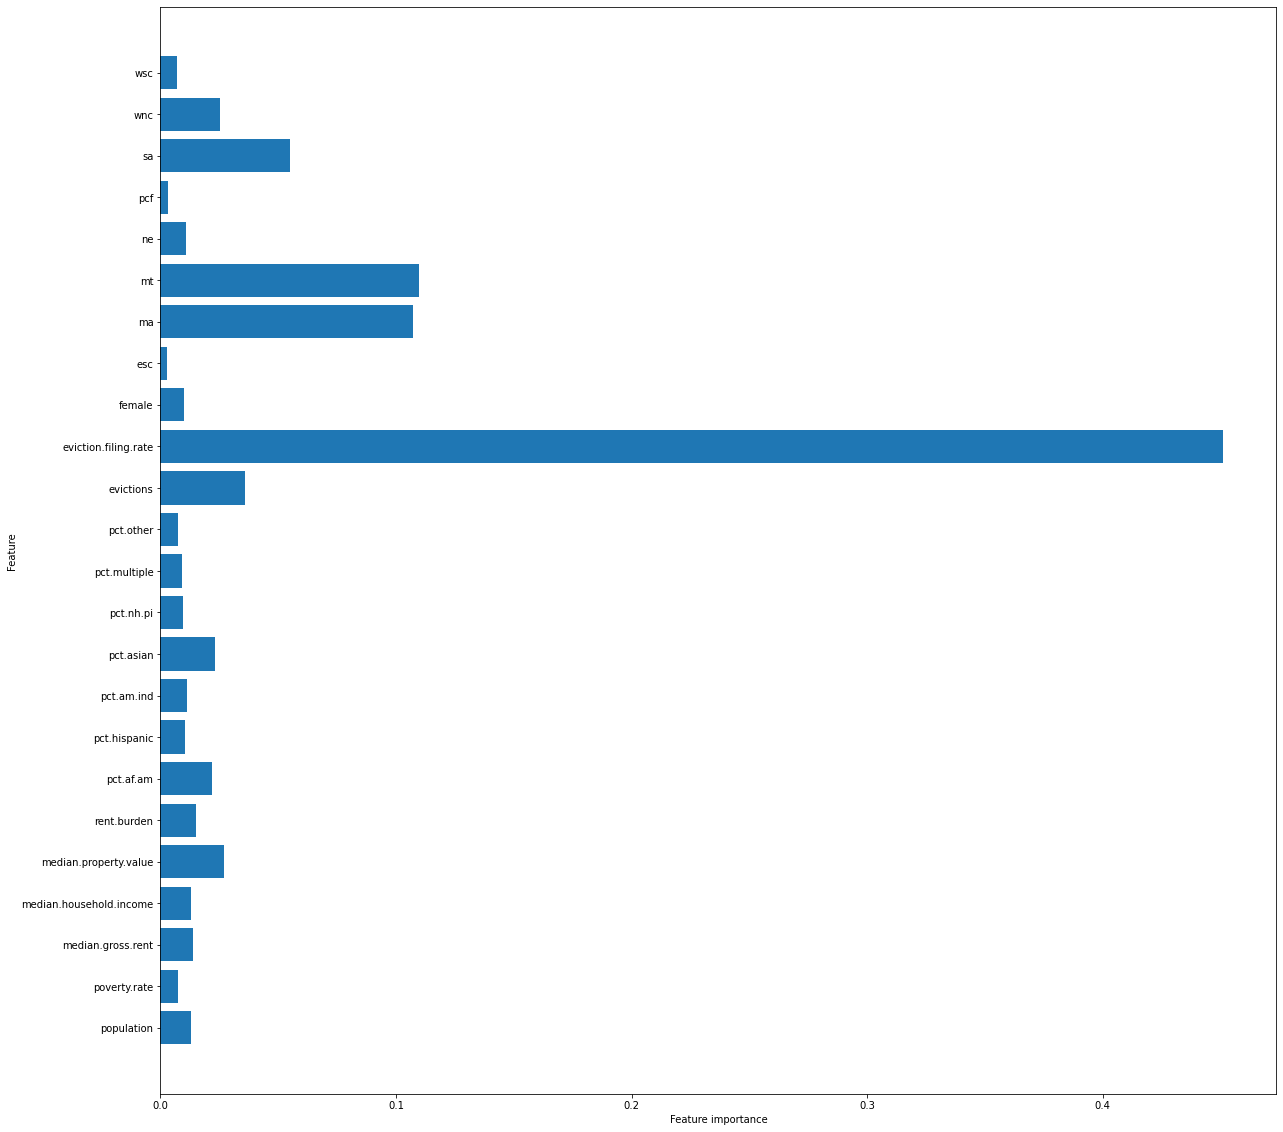

In [64]:
plot_feature_importances_base(iso_forest.xgb_iso)

**OBSERVATION**
- Feature importances have not changed much

In [50]:
param_grid = {
    'learning_rate' : [0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2],
    'sub_sample': [0.5, 0.7],
    
}

xgb_iso_model = GridSearchCV(estimator = XGBRegressor(), param_grid=param_grid, cv=3).fit(iso_forest.X2_train_scaled, iso_forest.y2_train)


[12:06:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:06:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:06:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

[12:07:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:07:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:07:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

[12:07:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:07:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:07:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

[12:08:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:08:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:08:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

In [51]:
rf_report(xgb_iso_model)

Variance --------------------------------------------
Train Variance: 0.9074758717729883
Test Variance: 0.9185893968064036
Max Error --------------------------------------------
Max Error Train: 25.678157234191907
Max Error Test: 16.846455307006835
RMSE --------------------------------------------
Train RMSE: 1.0605475620526668
Test RMSE: 1.0058682138583288
R2 --------------------------------------------
R2 Train: 0.9067418241799202
R2 Test: 0.9177381870973442


**OBSERVATION**
- Grid optimization does not lead to improvements 

# Permutation Importance

- Feature importances for tree based models can often be misleading 
- Plotting permutation importances may offer additional insight into how the model is using features

In [66]:
from sklearn.inspection import permutation_importance

result = permutation_importance(iso_forest.xgb_iso, X_test_scaled, y_test, n_repeats=10, random_state=0)

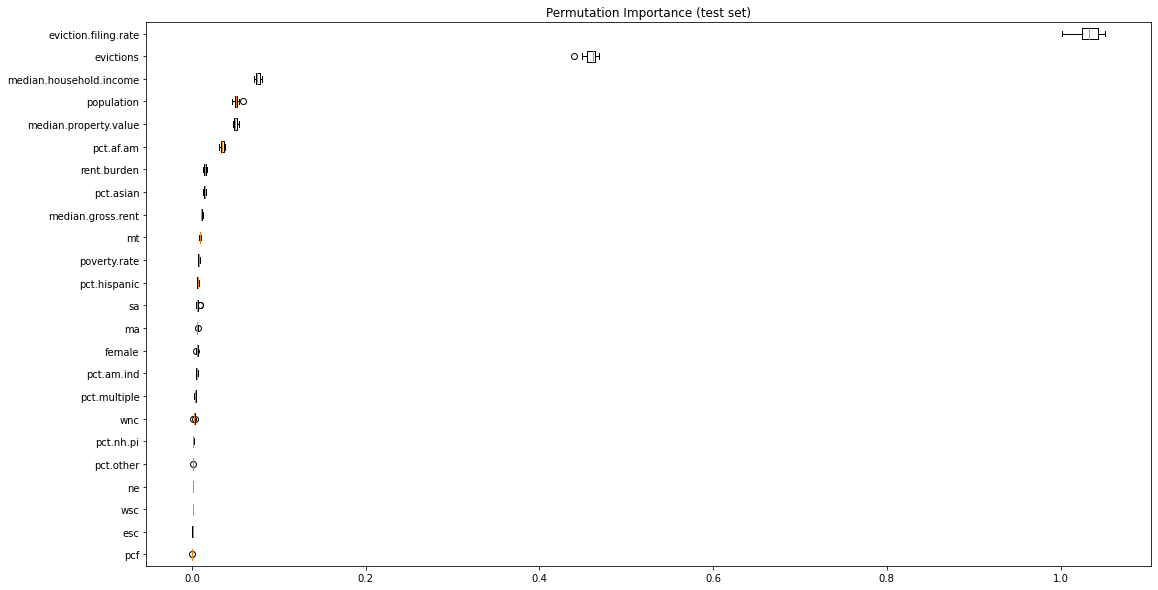

In [69]:
plt.subplots(figsize=(18,10))
feature_importance = iso_forest.xgb_iso.feature_importances_
sorted_idx = result.importances_mean.argsort()

plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_train.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")

plt.show()

In [ ]:
feature_importance

### Variance Threshold

In [ ]:
from sklearn.feature_selection import SelectFromModel


In [ ]:
m = SelectFromModel(XGBRegressor(learning_rate=0.2,
                                max_depth=6,
                                min_child_weight=2,
                                sub_sample=0.5))

m.fit(X_train_scaled, y_train)

In [ ]:
m.transform(X_train_scaled).shape

In [ ]:
m.score(X_test_scaled, y_test)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
var_thresh=VarianceThreshold(threshold=0.4)
var_thresh.fit(X_train_scaled)
sum(var_thresh.get_support())

In [ ]:
var_thresh.get_support()

In [ ]:
constant_columns = [column for column in X.columns
                   if column not in X.columns[var_thresh.get_support()]]


In [ ]:
constant_columns

In [ ]:
feature_select_df = drop_pop_df
for col in constant_columns:
    feature_select_df.drop(col, axis=1, inplace=True)

In [ ]:
X = feature_select_df.drop("eviction.rate", axis = 1)
y = feature_select_df['eviction.rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
xgb_base = XGBRegressor()
xgb_base_model = xgb_base.fit(X_train_scaled, y_train)

In [ ]:
rf_report(xgb_base_model)

In [ ]:
xgb_v2 = XGBRegressor()

param_grid = {
    'learning_rate' : [0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2],
    'sub_sample': [0.5, 0.7],
    
}

xgb_v2_model = GridSearchCV(estimator = xgb_v2, param_grid=param_grid, cv=3)
xgb_v2_model.fit(X_train_scaled, y_train)

In [ ]:
report_grid(xgb_v2_model)

### RFE

In [ ]:
sel = SelectFromModel(xgb_perm)
sel.fit(X_train_scaled, y_train)

In [ ]:
constant_columns = [column for column in X.columns
                   if column not in X.columns[sel.get_support()]]


In [ ]:
constant_columns

In [ ]:
feature_select_df = drop_pop_df
for col in constant_columns:
    feature_select_df.drop(col, axis=1, inplace=True)

In [ ]:
X1 = feature_select_df.drop("eviction.rate", axis = 1)
y1 = feature_select_df['eviction.rate']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25, random_state = 25)

scaler = StandardScaler()

X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

In [ ]:
xgb_v2 = XGBRegressor()

param_grid = {
    'learning_rate' : [0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2],
    'sub_sample': [0.5, 0.7],
    
}

xgb_v2_model = GridSearchCV(estimator = xgb_v2, param_grid=param_grid, cv=3)
xgb_v2_model.fit(X1_train_scaled, y1_train)

In [ ]:
rmse_train = math.sqrt(mean_squared_error(y1_train, xgb_v2_model.predict(X1_train_scaled)))
rmse_test = math.sqrt(mean_squared_error(y1_test, xgb_v2_model.predict(X1_test_scaled)))
    
    #calculating R2
r_sq_train = r2_score(y1_train, xgb_v2_model.predict(X1_train_scaled))
r_sq_test = r2_score(y1_test, xgb_v2_model.predict(X1_test_scaled))

print(rmse_train)
print(rmse_test)
print(r_sq_train)
print(r_sq_test)

# Counterfactuals

In [ ]:
pip install ceml

In [ ]:
from ceml.sklearn import generate_counterfactual